# YouTube Data Collection and Analysis

### To collect data from YouTube, we need to be clear about what data we need. Let’s collect data about the trending videos on YouTube to analyze and find what makes a video trend on YouTube.

### So, let’s start with data collection first. To collect data from YouTube, you need to set up an API. Here are the steps you can follow:

 - #### Go to Google Cloud Console.
 - #### Click on the project drop-down at the top, then “New Project”.
 - #### Enter a project name and click “Create”.
 - #### In the Google Cloud Console, navigate to “APIs & Services” > “Library”.
 - #### Search for “YouTube Data API v3” and click on it.
 - #### Click “Enable”.
 - #### Go to “APIs & Services” > “Credentials”.
 - #### Click “+ CREATE CREDENTIALS” and select “API key”.
 - #### Copy the generated API key.

In [38]:
!pip install google-api-python-client

#### Now, let’s get started with YouTube data collection using Python. I’ll collect data about the top 200 trending videos on YouTube:

In [39]:
import pandas as pd
from googleapiclient.discovery import build

# replace with your own API key
API_KEY = 'YOUR API KEY'

def get_trending_videos(api_key, max_results=200):
    # build the youtube service
    youtube = build('youtube', 'v3', developerKey=api_key)

    # initialize the list to hold video details
    videos = []

    # fetch the most popular videos
    request = youtube.videos().list(
        part='snippet,contentDetails,statistics',
        chart='mostPopular',
        regionCode='IN',  
        maxResults=50
    )

    # paginate through the results if max_results > 50
    while request and len(videos) < max_results:
        response = request.execute()
        for item in response['items']:
            video_details = {
                'video_id': item['id'],
                'title': item['snippet']['title'],
                'description': item['snippet']['description'],
                'published_at': item['snippet']['publishedAt'],
                'channel_id': item['snippet']['channelId'],
                'channel_title': item['snippet']['channelTitle'],
                'category_id': item['snippet']['categoryId'],
                'tags': item['snippet'].get('tags', []),
                'duration': item['contentDetails']['duration'],
                'definition': item['contentDetails']['definition'],
                'caption': item['contentDetails'].get('caption', 'false'),
                'view_count': item['statistics'].get('viewCount', 0),
                'like_count': item['statistics'].get('likeCount', 0),
                'dislike_count': item['statistics'].get('dislikeCount', 0),
                'favorite_count': item['statistics'].get('favoriteCount', 0),
                'comment_count': item['statistics'].get('commentCount', 0)
            }
            videos.append(video_details)

        # get the next page token
        request = youtube.videos().list_next(request, response)

    return videos[:max_results]

def save_to_csv(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

def main():
    trending_videos = get_trending_videos(API_KEY)
    filename = 'trending_videos.csv'
    save_to_csv(trending_videos, filename)
    print(f'Trending videos saved to {filename}')

if __name__ == '__main__':
    main()

Trending videos saved to trending_videos.csv


#### In the above code, we are using the YouTube Data API to fetch details of the top 200 trending videos in the INDIA, iterating through the API’s paginated responses to collect video details such as title, description, published date, channel information, tags, duration, definition, captions, and various engagement metrics like views, likes, and comments. The script compiles this information into a list, converts it into a pandas DataFrame, and saves the data to a CSV file named trending_videos.csv, allowing us to analyze trends and patterns in the collected video data.

In [40]:
import pandas as pd

trending_videos = pd.read_csv('trending_videos.csv')
print(trending_videos.head())

      video_id                                              title  \
0  ly7QhOGGp4g        THE END OF MAFIA BOSS | GTA 5 GAMEPLAY #154   
1  4SNThp0YiU4                  50 YouTubers Fight For $1,000,000   
2  3kmUS5HlNNc  Zor Ki Barsaat Hui (Song): Jubin Nautiyal, Roc...   
3  AbkbpbpHGw4  Chor Bazaar Shopping Challenge | सस्ते iPhone,...   
4  7Na3GdFBUQw  Anant Ambani and Radhika Merchant FIRST Speech...   

                                         description          published_at  \
0  THE END OF MAFIA BOSS | GTA 5 GAMEPLAY #154\n#...  2024-07-14T03:30:18Z   
1  I can’t believe how intense this video got\nTh...  2024-07-13T16:00:01Z   
2  This Monsoon, Witness the Love In Its True Sen...  2024-07-15T05:30:08Z   
3  Hello guys, is video me humne Delhi ke Chor Ba...  2024-07-15T07:31:21Z   
4  #anantradhikawedding \n#anantambani \n#radhika...  2024-07-15T16:03:27Z   

                 channel_id   channel_title  category_id  \
0  UCX8pnu3DYUnx8qy8V_c6oHg   Techno Gamerz           20

In [41]:
# check for missing values
missing_values = trending_videos.isnull().sum()

# display data types
data_types = trending_videos.dtypes

missing_values, data_types

(video_id          0
 title             0
 description       4
 published_at      0
 channel_id        0
 channel_title     0
 category_id       0
 tags              0
 duration          0
 definition        0
 caption           0
 view_count        0
 like_count        0
 dislike_count     0
 favorite_count    0
 comment_count     0
 dtype: int64,
 video_id          object
 title             object
 description       object
 published_at      object
 channel_id        object
 channel_title     object
 category_id        int64
 tags              object
 duration          object
 definition        object
 caption             bool
 view_count         int64
 like_count         int64
 dislike_count      int64
 favorite_count     int64
 comment_count      int64
 dtype: object)

#### The description column has 3 missing values. This is minor and can be handled as needed. The data types seem appropriate for most columns, but we may need to convert the published_at column to a datetime format and tags might need further processing. Let’s fix these changes:

In [42]:
# fill missing descriptions with "No description"
trending_videos['description'].fillna('No description', inplace=True)

# convert `published_at` to datetime
trending_videos['published_at'] = pd.to_datetime(trending_videos['published_at'])

# convert tags from string representation of list to actual list
trending_videos['tags'] = trending_videos['tags'].apply(lambda x: eval(x) if isinstance(x, str) else x)

C:\Users\User\AppData\Local\Temp\ipykernel_11112\4231922080.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trending_videos['description'].fillna('No description', inplace=True)


In [43]:
# descriptive statistics
descriptive_stats = trending_videos[['view_count', 'like_count', 'dislike_count', 'comment_count']].describe()

descriptive_stats

,view_count,like_count,dislike_count,comment_count
count,1.580000e+02,1.580000e+02,158.0,158.000000
mean,3.004052e+06,1.233632e+05,0.0,6678.537975
std,1.078673e+07,5.639350e+05,0.0,28845.514016
min,2.549200e+04,2.370000e+02,0.0,17.000000
25%,4.092010e+05,7.995750e+03,0.0,270.500000
50%,7.587045e+05,2.071150e+04,0.0,813.500000
75%,2.192223e+06,7.942300e+04,0.0,3337.500000
max,1.278382e+08,6.531963e+06,0.0,307707.000000


In [44]:
!pip install seaborn

In [45]:
!pip install matplotlib

#### Now, let’s have a look at the distribution of views, likes and comments of all the videos in the data:

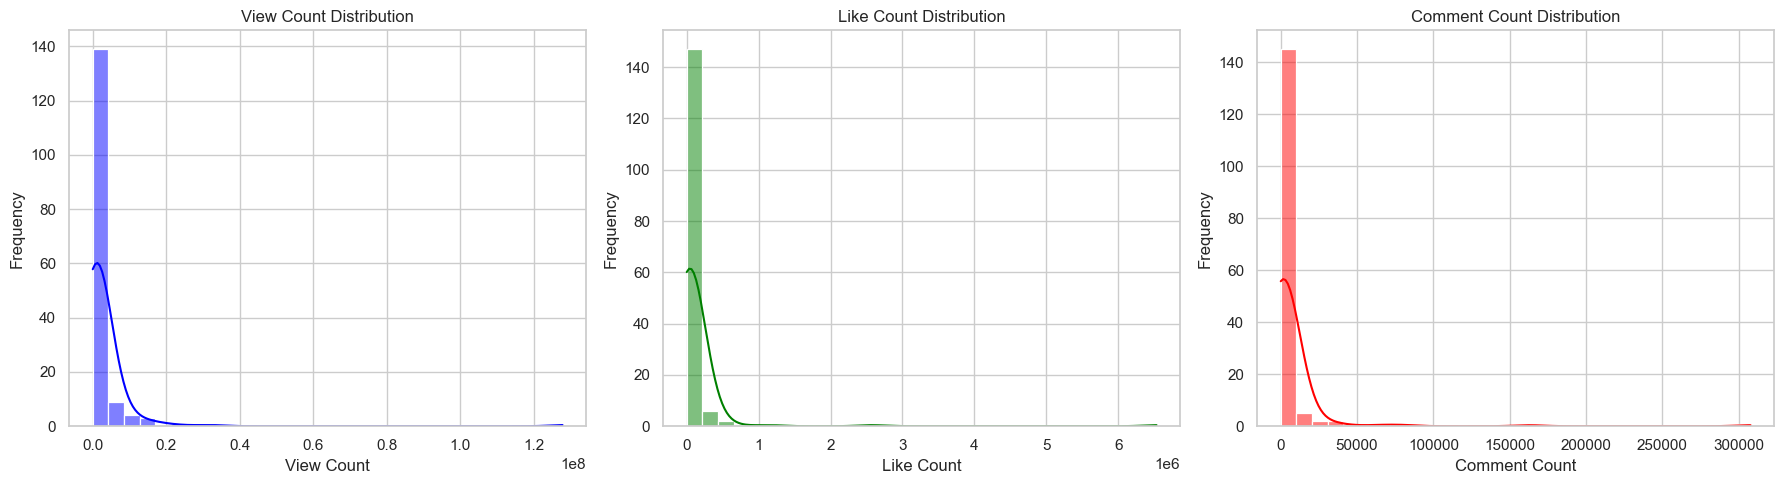

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# view count distribution
sns.histplot(trending_videos['view_count'], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('View Count Distribution')
axes[0].set_xlabel('View Count')
axes[0].set_ylabel('Frequency')

# like count distribution
sns.histplot(trending_videos['like_count'], bins=30, kde=True, ax=axes[1], color='green')
axes[1].set_title('Like Count Distribution')
axes[1].set_xlabel('Like Count')
axes[1].set_ylabel('Frequency')

# comment count distribution
sns.histplot(trending_videos['comment_count'], bins=30, kde=True, ax=axes[2], color='red')
axes[2].set_title('Comment Count Distribution')
axes[2].set_xlabel('Comment Count')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### The histograms show that the distributions of view counts, like counts, and comment counts are right-skewed, with most videos having lower counts and a few videos having very high counts. Now, let’s have a look at the correlation between likes, views, and comments:

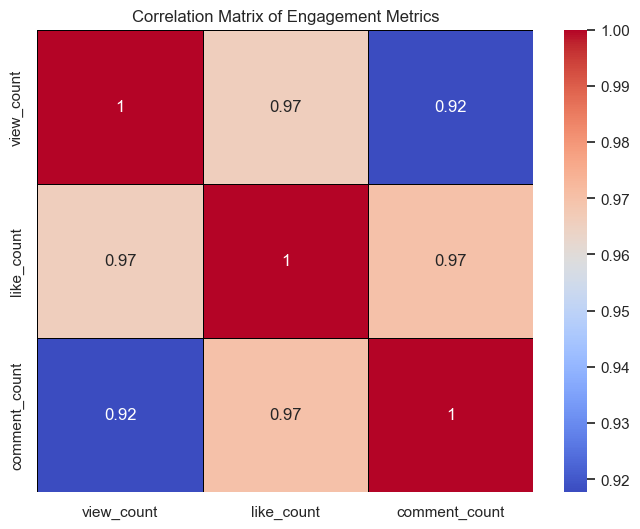

In [47]:
# correlation matrix
correlation_matrix = trending_videos[['view_count', 'like_count', 'comment_count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix of Engagement Metrics')
plt.show()

#### The heatmap confirms strong positive correlations between views, likes, and comments.

#### I noticed that I only collected the category ID of the video and not the category name. So, let’s collect the category names as well to analyze the categories of the trending videos:

In [48]:
from googleapiclient.discovery import build

API_KEY = 'YOUR API KEY'
youtube = build('youtube', 'v3', developerKey=API_KEY)

def get_category_mapping():
    request = youtube.videoCategories().list(
        part='snippet',
        regionCode='US'
    )
    response = request.execute()
    category_mapping = {}
    for item in response['items']:
        category_id = int(item['id'])
        category_name = item['snippet']['title']
        category_mapping[category_id] = category_name
    return category_mapping

# get the category mapping
category_mapping = get_category_mapping()
print(category_mapping)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


#### Now, here’s how we can analyze the number of trending videos by category:

C:\Users\User\AppData\Local\Temp\ipykernel_11112\1211282388.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=trending_videos['category_name'], order=trending_videos['category_name'].value_counts().index, palette='viridis')


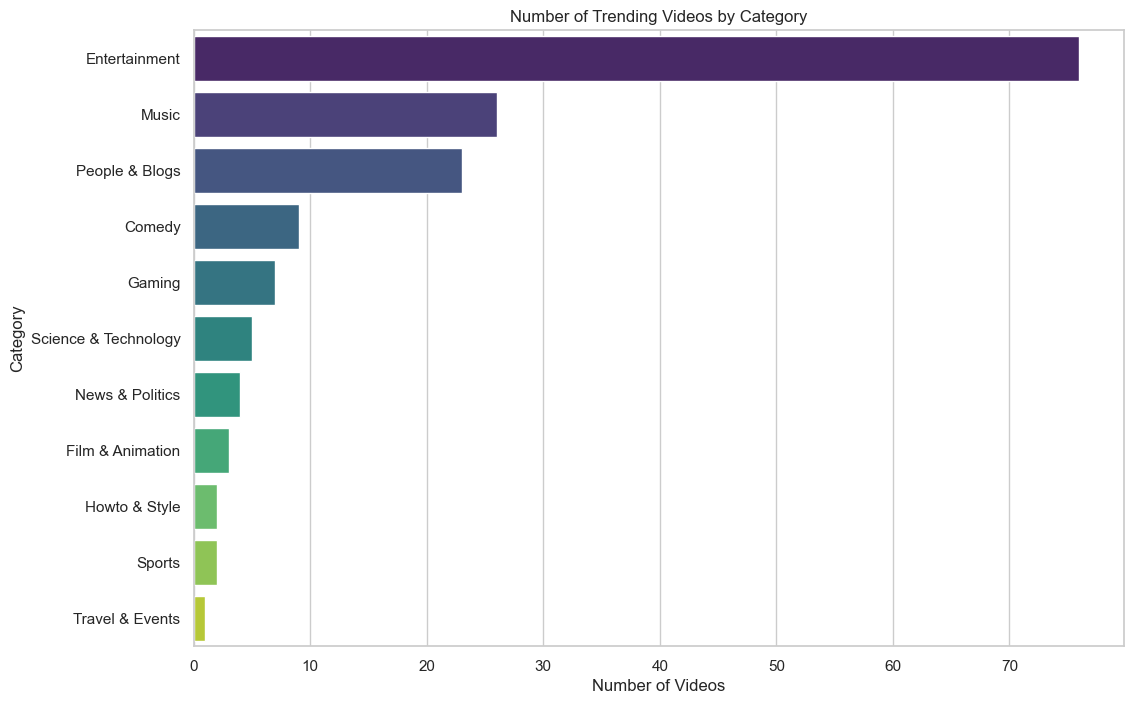

In [49]:
trending_videos['category_name'] = trending_videos['category_id'].map(category_mapping)

# Bar chart for category counts
plt.figure(figsize=(12, 8))
sns.countplot(y=trending_videos['category_name'], order=trending_videos['category_name'].value_counts().index, palette='viridis')
plt.title('Number of Trending Videos by Category')
plt.xlabel('Number of Videos')
plt.ylabel('Category')
plt.show()

#### The bar chart shows that the Entertainment, Music, People & Blogs and comedy categories have the highest number of trending videos. 

#### Now, let’s have a look at the average engagement metrics by category:

C:\Users\User\AppData\Local\Temp\ipykernel_11112\2552900410.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=category_engagement.index, x=category_engagement['view_count'], ax=axes[0], palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_11112\2552900410.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=category_engagement.index, x=category_engagement['like_count'], ax=axes[1], palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_11112\2552900410.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=category_enga

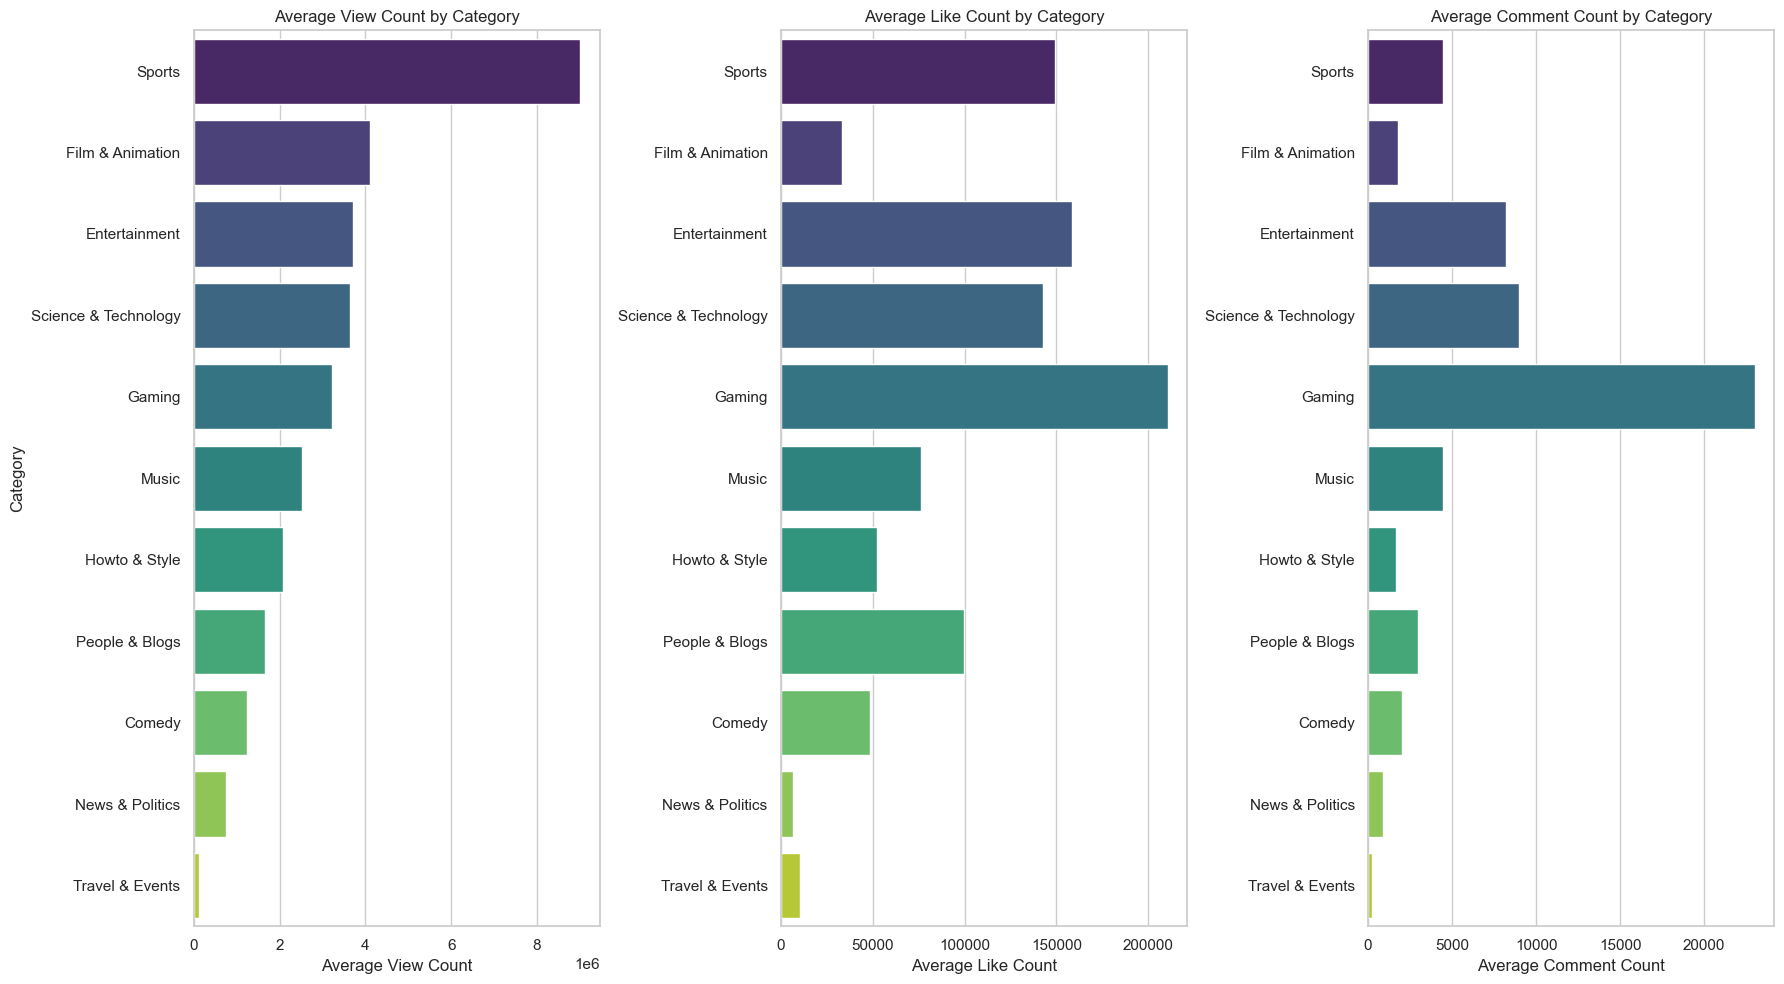

In [50]:
# average engagement metrics by category
category_engagement = trending_videos.groupby('category_name')[['view_count', 'like_count', 'comment_count']].mean().sort_values(by='view_count', ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# view count by category
sns.barplot(y=category_engagement.index, x=category_engagement['view_count'], ax=axes[0], palette='viridis')
axes[0].set_title('Average View Count by Category')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Category')

# like count by category
sns.barplot(y=category_engagement.index, x=category_engagement['like_count'], ax=axes[1], palette='viridis')
axes[1].set_title('Average Like Count by Category')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('')

# comment count by category
sns.barplot(y=category_engagement.index, x=category_engagement['comment_count'], ax=axes[2], palette='viridis')
axes[2].set_title('Average Comment Count by Category')
axes[2].set_xlabel('Average Comment Count')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

#### Sports has the highest average view counts, likes, and comments. Gaming also shows high engagement, especially in like counts and comment counts.

#### Now, let’s analyze the content and duration of the videos. But first, we need to convert the duration from ISO 8601 format to seconds:

In [51]:
!pip install isodate
import isodate

# convert ISO 8601 duration to seconds
trending_videos['duration_seconds'] = trending_videos['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())

trending_videos['duration_range'] = pd.cut(trending_videos['duration_seconds'], bins=[0, 300, 600, 1200, 3600, 7200], labels=['0-5 min', '5-10 min', '10-20 min', '20-60 min', '60-120 min'])

#### In the above code, we are using the isodate library to convert the duration of each video from the ISO 8601 format to seconds, which allows for numerical analysis. After converting the durations, we are categorizing the videos into different duration ranges (0-5 minutes, 5-10 minutes, 10-20 minutes, 20-60 minutes, and 60-120 minutes) by creating a new column called duration_range. This categorization enables us to analyze and compare the engagement metrics of videos within specific length intervals, providing insights into how video length influences viewer behaviour and video performance.

#### Now, let’s analyze the content and the duration of videos:

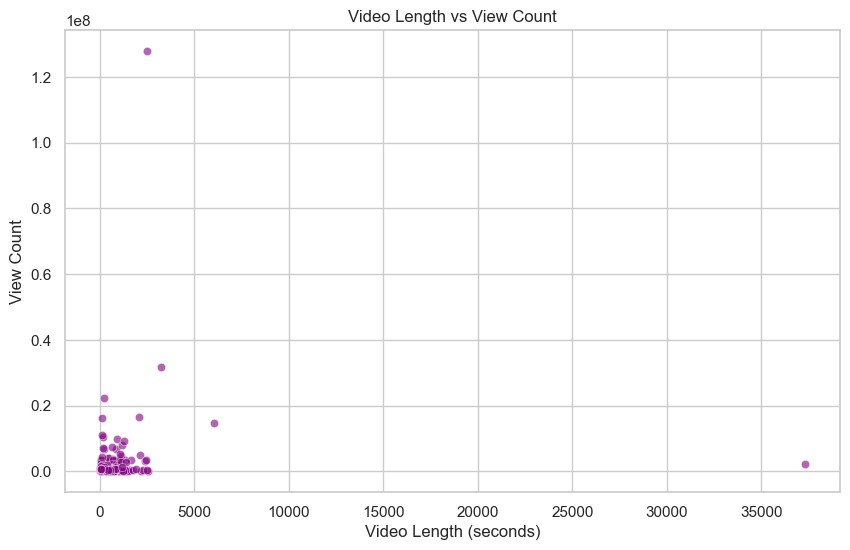

C:\Users\User\AppData\Local\Temp\ipykernel_11112\4263121044.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_engagement = trending_videos.groupby('duration_range')[['view_count', 'like_count', 'comment_count']].mean()
C:\Users\User\AppData\Local\Temp\ipykernel_11112\4263121044.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=length_engagement.index, x=length_engagement['view_count'], ax=axes[0], palette='magma')
C:\Users\User\AppData\Local\Temp\ipykernel_11112\4263121044.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=Fal

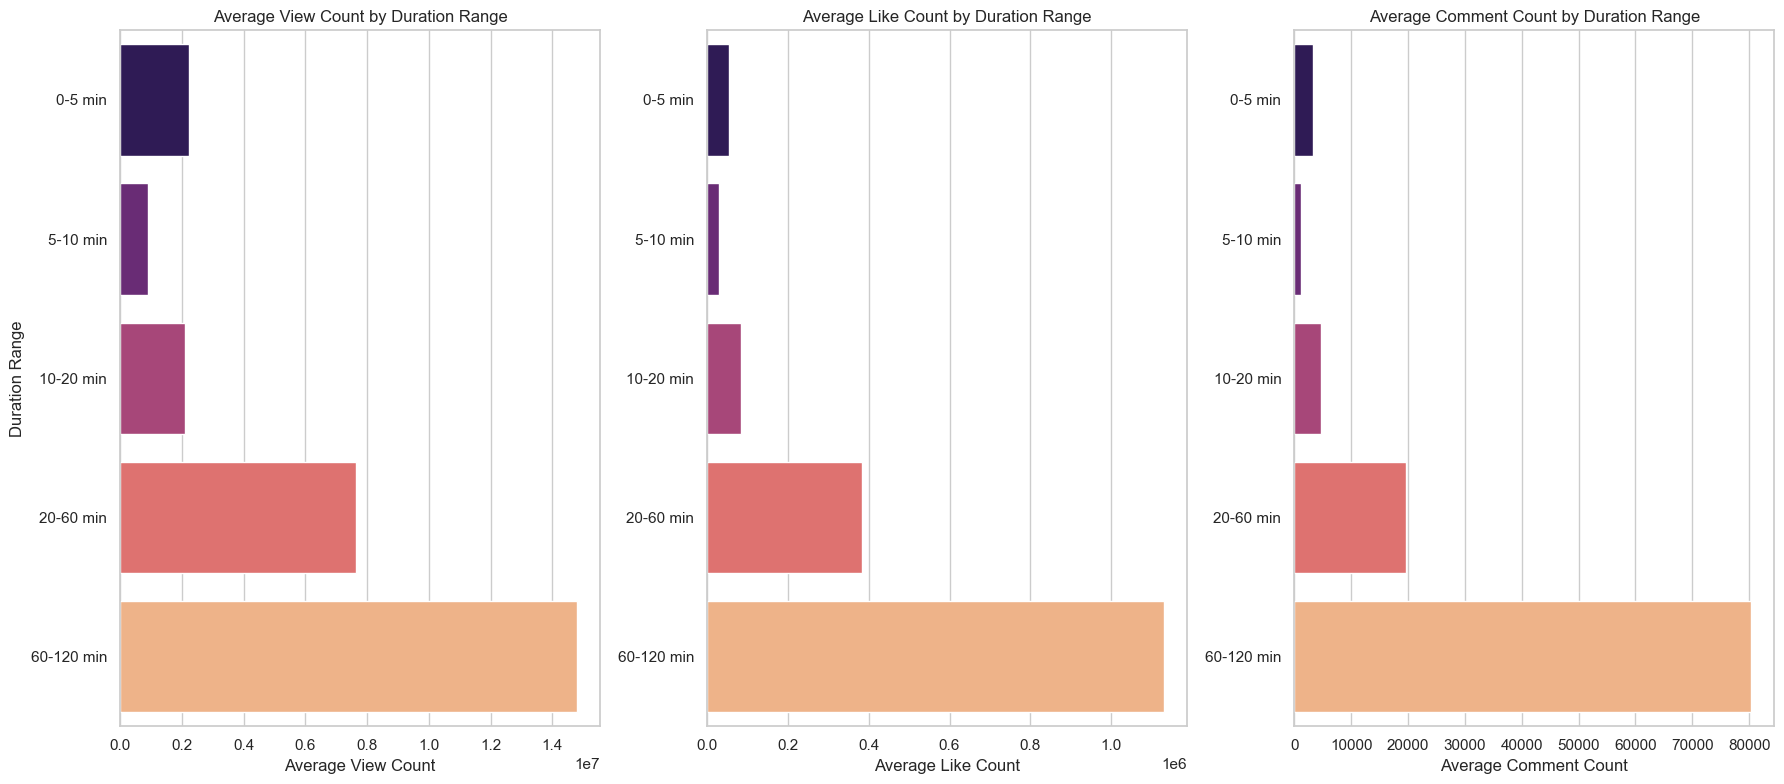

In [52]:
# scatter plot for video length vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration_seconds', y='view_count', data=trending_videos, alpha=0.6, color='purple')
plt.title('Video Length vs View Count')
plt.xlabel('Video Length (seconds)')
plt.ylabel('View Count')
plt.show()

# bar chart for engagement metrics by duration range
length_engagement = trending_videos.groupby('duration_range')[['view_count', 'like_count', 'comment_count']].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# view count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['view_count'], ax=axes[0], palette='magma')
axes[0].set_title('Average View Count by Duration Range')
axes[0].set_xlabel('Average View Count')
axes[0].set_ylabel('Duration Range')

# like count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['like_count'], ax=axes[1], palette='magma')
axes[1].set_title('Average Like Count by Duration Range')
axes[1].set_xlabel('Average Like Count')
axes[1].set_ylabel('')

# comment count by duration range
sns.barplot(y=length_engagement.index, x=length_engagement['comment_count'], ax=axes[2], palette='magma')
axes[2].set_title('Average Comment Count by Duration Range')
axes[2].set_xlabel('Average Comment Count')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

#### The scatter plot shows a slight positive correlation between video length and view count, indicating lenghty videos tend to have higher view counts. Videos in the 60 - 120 minute range have the highest average view counts, likes, and comments. Engagement increases as video length increases.

#### Now, let’s analyze the relationship between views and number of tags used in the video:

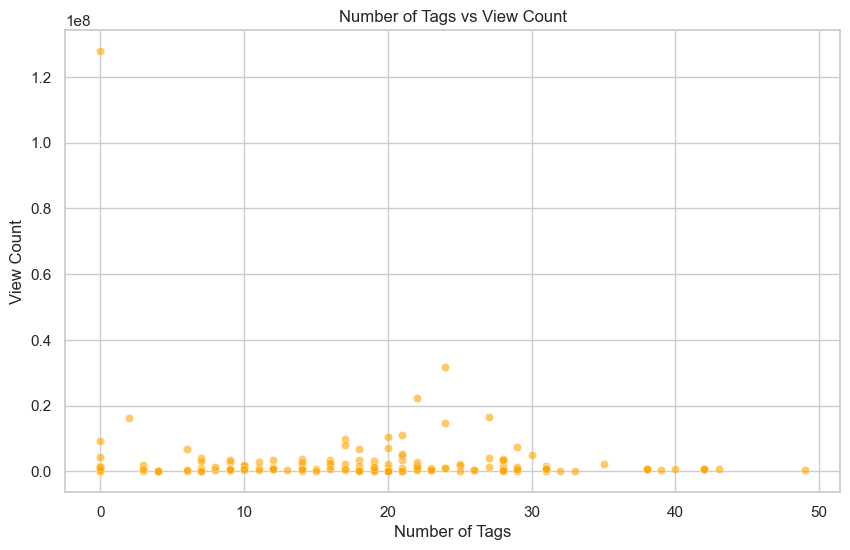

In [53]:
# calculate the number of tags for each video
trending_videos['tag_count'] = trending_videos['tags'].apply(len)

# scatter plot for number of tags vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tag_count', y='view_count', data=trending_videos, alpha=0.6, color='orange')
plt.title('Number of Tags vs View Count')
plt.xlabel('Number of Tags')
plt.ylabel('View Count')
plt.show()

#### The scatter plot shows a very weak relationship between the number of tags and view count, suggesting that the number of tags has minimal impact on a video’s view count.

#### Now, let’s see if there’s an impact of the time a video is posted on its views:

C:\Users\User\AppData\Local\Temp\ipykernel_11112\1314667626.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='publish_hour', data=trending_videos, palette='coolwarm')


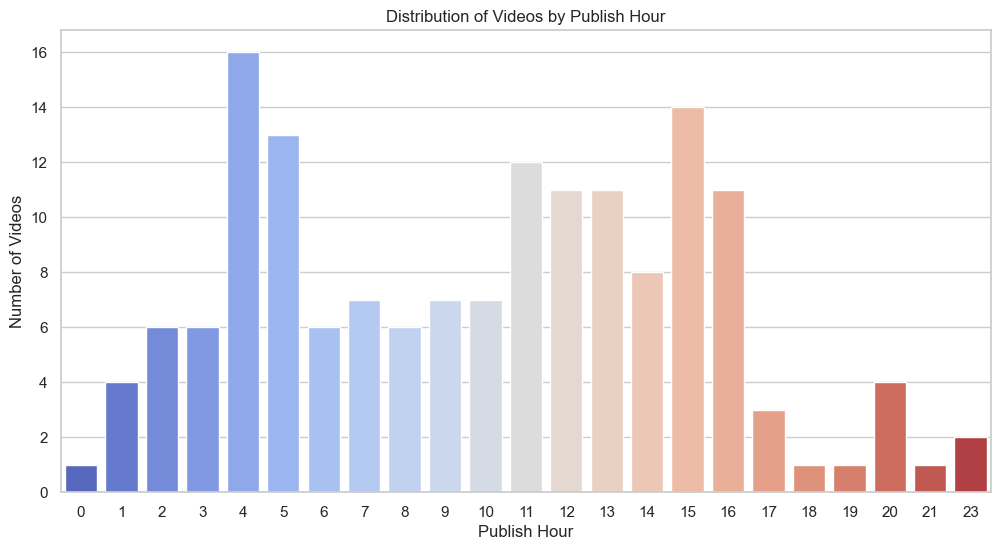

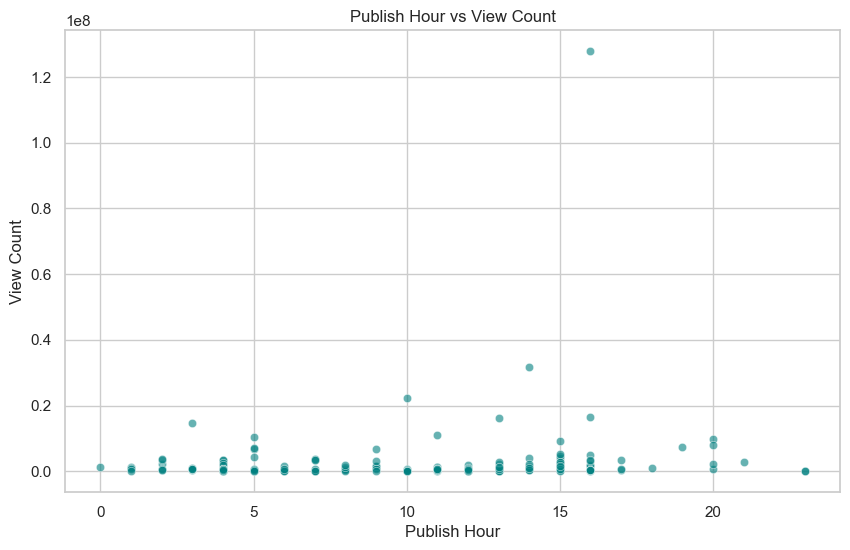

In [54]:
# extract hour of publication
trending_videos['publish_hour'] = trending_videos['published_at'].dt.hour

# bar chart for publish hour distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='publish_hour', data=trending_videos, palette='coolwarm')
plt.title('Distribution of Videos by Publish Hour')
plt.xlabel('Publish Hour')
plt.ylabel('Number of Videos')
plt.show()

# scatter plot for publish hour vs view count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='publish_hour', y='view_count', data=trending_videos, alpha=0.6, color='teal')
plt.title('Publish Hour vs View Count')
plt.xlabel('Publish Hour')
plt.ylabel('View Count')
plt.show()

#### The distribution shows that most videos are published between 4am to 5am and 11am to 4pm, indicating this may be an optimal time for uploading videos. There is a very weak negative relationship between publish hour and view count, suggesting that the hour of publication has minimal impact on engagement metrics.

### Conclusion

#### So, here’s my conclusion on what makes a video trend on YouTube:

 - #### Encourage viewers to like and comment on videos to boost engagement metrics.
 - #### Aim to create long videos (60min to 120min) for higher engagement, especially for categories like Gaming and Entertainment.
 - #### Schedule video uploads around peak times (11 AM – 4 PM) to maximize initial views and engagement.